![](img/563_banner.png)

# Lecture 6: Using word embeddings, manifold learning

UBC Master of Data Science program, 2023-24

Instructor: Varada Kolhatkar

## Lecture plan, imports, and LOs

### Lecture plan

- Context and motivation (~5 mins)
- Using word embeddings in text classification (~20 mins)
- Q&A (~5 mins)
- Break (~5 mins)
- Product similarity using word2vec (~15 mins)
- t-SNE (~15 mins)
- Final remarks, summary, reflection (~5 mins)

### Imports 

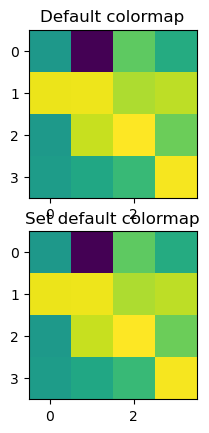

In [1]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

sys.path.append("code/.")

import re
import string

import matplotlib.pyplot as plt
from sklearn import datasets, manifold
from sklearn.decomposition import PCA
from plotting_functions import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

plt.rcParams["font.size"] = 14
import matplotlib.cm as cm

%matplotlib inline
pd.set_option("display.max_colwidth", 0)

<br><br>

### Learning outcomes

From this lecture, students are expected to be able to:

- Explain how could we evaluate quality of word embeddings.  
- Explain how can one represent sentences and text with word representations. 
- Use word embeddings in text classification and document clustering using spaCy. 
- Explain limitations associated with the approaches used to create sentence embeddings from word embeddings.   
- Use word2vec algorithm to build a product recommendation system using customer purchase history.  
- Broadly explain the idea of manifold learning and t-SNE. 
- Visualize data using t-SNE.  

<br><br><br><br>

## 1. Context and motivation

Two main topics for today
- Using word embeddings in ML applications
    - In the last lecture we talked about word2vec. 
    - We used word embeddings to find similarity between words and phrases and to find analogies.  
    - How do we actually use them in machine learning applications?
- Manifold learning 

**Evaluating quality of word vectors**

- Before using word embeddings in your applications, it's a good idea to examine their quality. 
- How do we evaluate the quality of embeddings? 
    - Examine a number of word pairs for similarity scores. 
    - Examine different analogies for stereotypes and biases they encode.  
    - Visualize embeddings in two dimensions. 

**Example evaluation with TOEFL multiple-choice vocabulary tests**

* Compare it to human judgment on the similarity between words.
* Taking TOEFL multiple-choice vocabulary tests.
    - **Levied**  is closest in meaning to:
      _imposed, believed, requested, correlated_

In [2]:
import gensim.downloader as api

google_news_vectors = api.load("word2vec-google-news-300")

In [3]:
google_news_vectors.most_similar("levied")

[('levying', 0.7044811844825745),
 ('Dedicating_fines', 0.5996160507202148),
 ('levies', 0.5890565514564514),
 ('imposed', 0.5830394625663757),
 ('fines_levied', 0.5777179598808289),
 ('Levying', 0.5654435753822327),
 ('Osteens_paid', 0.5609163641929626),
 ('levy', 0.5559998750686646),
 ('fines', 0.5462918281555176),
 ('Longe_Velazquez', 0.5221693515777588)]

**Visualization of embeddings**

- Let's visualize word vectors for specific words from Google News pre-trained embeddings. 

In [4]:
words = google_news_vectors.index_to_key

In [5]:
google_news_vectors["peace"].shape

(300,)

The vectors are 300 dimensional. How do we visualize them? 

In [6]:
positive = [
    "amazing",
    "admirable",
    "awesome",
    "outstanding",
    "extraordinary",
    "exceptional",
    "fantastic",
]
negative = [
    "rotten",
    "stinky",
    "dirty",
    "annoying",
    "disgusting",
    "fake",
    "hideous",
    "bad",
    "waste",
    "awful",
]

neutral = [
    "apathetic",
    "urgent",
    "detached",
    "indifferent",
    "wikipedia",
]

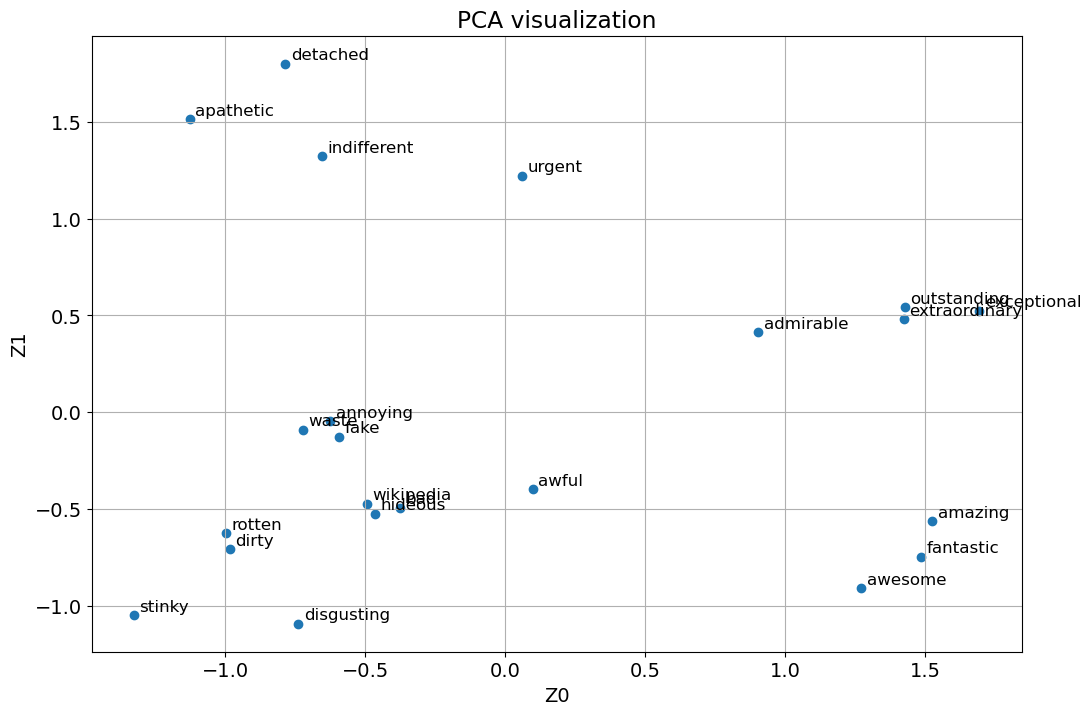

In [7]:
plt.figure(figsize=(12, 8))
plt.title("PCA visualization")

X = google_news_vectors[positive + negative + neutral]
pca = PCA(n_components=2)
Z = pca.fit_transform(X)
# # create a scatter plot of the projection
plt.scatter(Z[:, 0], Z[:, 1])
words = positive + negative + neutral
for i, word in enumerate(words):
    plt.annotate(word, xy=(Z[i, 0] + 0.02, Z[i, 1] + 0.02), size=12)
plt.xlabel("Z0")
plt.ylabel("Z1")
plt.grid()
plt.show()

- Even in two dimensional projects we see three distinct clusters for positive, negative, and neutral words! 
- Not sure why the word _wikipedia_ is placed among negative words.  

In [8]:
google_news_vectors.most_similar("wikipedia", 10)

[('en.wikipedia.org_wiki', 0.4892520010471344),
 ('Wikepedia', 0.471505731344223),
 ('google', 0.45259714126586914),
 ('faqs', 0.444589763879776),
 ('htm', 0.4418445825576782),
 ('cgi_bin', 0.4352087378501892),
 ('Wikipedia', 0.4266732633113861),
 ('##.html', 0.42112863063812256),
 ('answers.com', 0.4172719120979309),
 ('Wikpedia', 0.41681769490242004)]

- PCA is good first approach to transform data so that we can plot it in two dimensions.
- There is a class of algorithms for visualization called **manifold learning algorithms** which allow for much more complex mappings and better visualizations. 
- A particularly useful one is the t-SNE algorithm which we'll talk about in the second part of the lecture. 

<br><br><br><br>

## 2. Using word embeddings in document similarity and text classification

- Assuming that we have reasonable representations of words. 
- How do we represent meaning of paragraphs or documents?
- Two simple approaches
    - Averaging embeddings
    - Concatenating embeddings

### 2.1 Averaging embeddings

<blockquote>
All empty promises
</blockquote>
    
$(embedding(all) + embedding(empty) + embedding(promise))/3$

- We can do this conveniently with [spaCy](https://spacy.io/usage/linguistic-features#vectors-similarity). 
- We need `en_core_web_md` or bigger model to access word vectors. 
- You can download the model by going to command line and in your course `conda` environment and download `en_core_web_md` as follows.   

```
conda activate 563
python -m spacy download en_core_web_md
```

In [10]:
import spacy

nlp = spacy.load("en_core_web_md")

We can access word vectors for individual words in `spaCy` as follows. 

In [11]:
nlp("empty").vector[0:10]

array([ 0.010289,  4.9203  , -0.48081 ,  3.5738  , -2.2516  ,  2.1697  ,
       -1.0116  ,  2.4216  , -3.7343  ,  3.3025  ], dtype=float32)

We can get average embeddings for a sentence or a document in `spaCy` as follows: 

In [12]:
s = "All empty promises"
doc = nlp(s)
avg_sent_emb = doc.vector
print(avg_sent_emb.shape)
print("vector for: {}\n{}".format((s), (avg_sent_emb[0:10])))

(300,)
vector for: All empty promises
[-0.459937    1.9785299   1.0319      1.5123      1.4806334   2.73183
  1.204       1.1724668  -3.5227966  -0.05656664]


- Now that we have representation for sentences we can get similarity between documents as follows. 
- Note that this is based on average embeddings of each sentence. 

In [13]:
doc1 = nlp("Deep learning is very popular these days.")
doc2 = nlp("Data Science is dominated by neural networks.")
doc3 = nlp("Today I ate home-made fresh bread.")

# Similarity of two documents
print(doc1, "<->", doc2, doc1.similarity(doc2))
print(doc2, "<->", doc3, doc2.similarity(doc3))

Deep learning is very popular these days. <-> Data Science is dominated by neural networks. 0.62099759440504
Data Science is dominated by neural networks. <-> Today I ate home-made fresh bread. 0.1728727999792462


- Do these scores make sense? 
    - Kind of. 

### 2.2 Concatenating embeddings

<blockquote>
All empty promises
</blockquote>

- $embedding(all)$ $embedding(empty)$ $embedding(promise)$
- Might have to chop some text in order to make fixed-sized vectors to feed into ML algorithms.


**You'll see real benefit of word embeddings when we talk about deep learning for text data in DSCI 575!**

### 2.3 Airline sentiment analysis using average embedding representation 

- Let's try average embedding representation for airline sentiment analysis.
- You can download the dataset from [here](https://www.kaggle.com/jaskarancr/airline-sentiment-dataset). 

In [14]:
df = pd.read_csv("data/Airline-Sentiment-2-w-AA.csv", encoding="ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


What are we trying to do?

- Try sentiment analysis with bag-of-words representation 
- Try sentiment analysis with embedding representation

In [15]:
from sklearn.model_selection import cross_validate, train_test_split

train_df, test_df = train_test_split(df, test_size=0.7, random_state=123)
X_train, y_train = train_df["text"], train_df["airline_sentiment"]
X_test, y_test = test_df["text"], test_df["airline_sentiment"]

**Bag-of-words representation for sentiment analysis**

In [16]:
pipe = make_pipeline(
    CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000)
)
pipe.named_steps["countvectorizer"].fit(X_train)
X_train_transformed = pipe.named_steps["countvectorizer"].transform(X_train)
print("Data matrix shape:", X_train_transformed.shape)
pipe.fit(X_train, y_train);

Data matrix shape: (4392, 7290)


In [17]:
print("Train accuracy {:.2f}".format(pipe.score(X_train, y_train)))
print("Test accuracy {:.2f}".format(pipe.score(X_test, y_test)))

Train accuracy 0.96
Test accuracy 0.76


- Large gap between train and test scores. Overfitting. 
- Test score is kind of low. 

**Sentiment analysis with average embedding representation**

- Let's try average embedding representation using `spaCy`. 
- How can we create average embedding representation for each example using `spaCy`? 
- When you want to process large volumes of text, pre-trained models from `spaCy` are usually more efficient if you let them work on batches of texts. `spaCy`’s `nlp.pipe` method takes an iterable of texts and yields processed Doc objects. The batching is done internally.

In [18]:
X_train_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_train)])
X_test_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_test)])

- We have reduced dimensionality from 7,290 to 300! 
- Let's examine the average embedding representation. 

In [19]:
X_train_embeddings.shape

(4392, 300)

In [20]:
X_train_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.715993,3.024856,-2.961218,-1.086345,-0.123557,1.467904,0.605043,1.832471,-1.459403,1.153033,...,1.261182,-1.051472,2.565378,-0.258263,-0.795342,-1.271816,1.410173,0.542111,-2.229493,0.399477
1,-1.152375,2.198183,-1.196150,-0.821115,-3.005700,1.658515,-1.853075,0.124950,-1.718775,0.598058,...,2.667635,1.316750,3.139700,-2.422225,-1.294870,0.072875,0.978452,0.597100,-0.651000,-0.551250
2,-1.602497,0.539487,-3.950199,-0.231717,3.366309,1.425058,0.639011,5.092289,-0.926476,1.030533,...,0.059342,0.789078,0.788769,-0.503864,-2.172607,1.765752,-0.544203,0.092374,-1.417742,0.930287
3,-1.045790,0.533385,0.852775,0.121400,1.923370,-1.106279,0.762420,1.016824,0.512271,-0.578976,...,-0.834322,0.673255,-0.743473,0.170571,1.052062,1.092318,-0.634580,0.277500,-1.026040,-0.318937
4,-1.155673,0.535273,-3.451900,0.234435,0.763545,0.880550,-0.420211,2.144348,-1.498447,1.755801,...,-0.229825,-0.634347,1.154722,-1.226543,-1.740660,-1.192653,-0.402632,0.358389,-1.776468,-0.638905


**Sentiment classification using average embeddings**

- What are the train and test accuracies with average word embedding representation? 

In [21]:
lgr = LogisticRegression(max_iter=1000)
lgr.fit(X_train_embeddings, y_train)
print("Train accuracy {:.2f}".format(lgr.score(X_train_embeddings, y_train)))
print("Test accuracy {:.2f}".format(lgr.score(X_test_embeddings, y_test)))

Train accuracy 0.82
Test accuracy 0.77


- The test accuracy is a bit better with less overfitting. 
- Note that the embeddings are trained on a completely different corpus and we are leveraging semantic similarities it has learned from this huge training corpus to represent sentences from our fairly small corpus.

**`spaCy`'s pre-trained embeddings**
- `spaCy`'s pre-trained embeddings are trained on [OntoNotes corpus](https://catalog.ldc.upenn.edu/LDC2013T19).
- This corpus has a collection of different styles of texts such as telephone conversations, newswire, newsgroups, broadcast news, broadcast conversation, weblogs, religious texts. 
- If you are working with a specific style (e.g., tweets or healthcare) you may want to use different pre-trained embeddings. In that case you'll have to get average embeddings on your own. 

**Comments on using average embeddings in your applications**

- Maintain realistic expectations about the information average embeddings provide. 
- Since embedding of a phrase or a sentence is the average of embeddings of words in it we do not necessarily get expected representation of text. 
    - Example: embedding of "machine learning" is going to be average of embedding of "machine" and embedding of "learning" which is not necessarily representative of the phrase "machine learning". 
- For long sentences or documents the average embedding can get very noisy, as there will be a mix of many different signals.  

### 2.3 Extensions and more advanced models

- [Include phrases](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
    * New York : New York Times :: Vancouver : Vancouver Sun?
- Contextual representations of words ([ELMo](https://github.com/allenai/allennlp/blob/master/tutorials/how_to/elmo.md))
    * I went to the **bank** to deposit a cheque. 
    * She loves to walk along the <b>bank</b> of a river, and look into the water.
- [doc2vec](https://radimrehurek.com/gensim/models/doc2vec.html) and [paragraph2vec](https://arxiv.org/abs/1405.4053)
    * Learns fixed-length feature representations from variable-length pieces of texts

<br><br><br><br>

## ❓❓ Questions for you

### Exercise 6.1 Select all of the following statements which are **True** (iClicker)

- (A) Consider Google News pre-trained word2vec embeddings. If I take word vector for "Computer_Science" and an average of the word vectors for "Computer" and "Science", they will result in the same word vector.
- (B) One of the problems with using pre-trained embeddings built on a text in a particular domain with text in another domain is that there could be many unknown words. 
- (C) Once you have a trained word2vec model, finding most similar items means finding $k$-nearest neighbours on your word embeddings. 
- (D) Instead of getting sentence embeddings, you could have used average word embeddings of recipe names in lab1. 
- (E) When you are using average embedding representation on large documents, the representation can get quite noisy.  

<br><br><br><br>

```{admonition} Exercise 6.1: V's Solutions!
:class: tip, dropdown

- (A) 
- (B) 
- (C) 
- (D) 
- (E) 
```

<br><br><br><br>

## 3. word2vec for product recommendation

word2vec is not limited to text and words and it has been used in many different domains and for many different applications.
- Examples
    - [graph2vec](https://github.com/benedekrozemberczki/graph2vec)
    - [node2vec](https://github.com/topics/node2vec)
    - [song2vec](https://github.com/lihenryhfl/song2vec)
    - ...             

- In the lab you will be using word2vec for product recommendation. 
- word2vec exploits the sequential nature of text data and assumes that the words in similar contexts tend to be similar or related. 
- We could apply the same intuition to product purchasing behaviour of customers! 
    - If we consider products bought together with each other as contexts of each other, then we can say that the products that occur in similar contexts are related or similar. 
   

### 3.1 Purchase history example
- Bike light and waterproof pants occur in similar contexts
- How about recommending waterproof pants to Sam and Bike light to Jamie?

<img src="img/customer_purchase_history_example.png" width="600" height="600">

(Credit: https://www.bicycling.com/bikes-gear/g20011461/winter-cycling-gear-0/)

- How to train word2vec for this?
- What are words, sentences, and vocabulary?
    - Words $\rightarrow$ products
    - Sentences $\rightarrow$ purchase histories 
    - Vocabulary $\rightarrow$ all unique products

![](img/customer_purchase_history_labeled.png)
<!-- <img src="img/customer_purchase_history_labeled.png" width="800" height="800"> -->

(Credit: https://www.bicycling.com/bikes-gear/g20011461/winter-cycling-gear-0/)

- The idea is to model similarity/relatedness between products based on the distributional hypothesis; the products that occur in similar contexts tend to be related/similar.  
- Using the word2vec algorithm, we learn short and dense representations for all products based on the contexts in which they appear.
- If we have a large dataset, we learn meaningful representations of products.  
- To train word2vec model we need: 
    - preprocessed corpus
    - embedding dimension
    - window size

Let's prepare the data for training word2vec. 
- Create a list of lists of purchase histories for all customers. 
- We want the data in the following format.

    ```
    [
     [item1_customer1, item2_customer1, ...], # purchase history for customer1
     [item1_customer2, item2_customer2, ...], # purchase history for customer2
     ...
     [item1_customer100, item2_customer100, ...], # purchase history for customer100
     ...
     ]
    ```

- Each inner list corresponds to purchase history of a customer. 
- Elements of each inner list are items bought by that particular customer ordered by time when they were bought. 
- Each inner list of items purchased by a customer is equivalent to a sentence in a typical word2vec model. 
    - ```[item1_customer1, item2_customer1, ....]``` 
- Each item within each inner list corresponds to a word in a typical word2vec model. 
    - `item1_customer2` would be equivalent to a word in a typical word2vec model. 
- The items following and preceding a given item form context of the given item. 

- Now that you have input for the word2vec algorithm, you can train is by setting the appropriate hyperparameters
    - window size
    - embedding dimensions

- What to do with the trained product embeddings? 
- With the trained model, we can find products similar to the product of interest in the vector space and recommend it to the user.  
- Example: Recommend waterproof pants to Sam and bike light to Jamie.


<img src="img/customer_purchase_history_example.png" width="600" height="600">

(Credit: https://www.bicycling.com/bikes-gear/g20011461/winter-cycling-gear-0/)

<br><br><br><br>

## 4. Manifold learning 

### 4.1 Definition and motivation

- One of the major goals of unsupervised learning is uncovering underlying structure of the data. 
- **Manifold learning** is about understanding how the data is organized on a geometrically simpler shape that is twisted and folded in a higher-dimensional space.
- It is a type of unsupervised learning that aims to uncover the simpler, intrinsic structure hidden within complex, high-dimensional data. 

- The idea is that you have some shape in 2D and it's embedded in a higher dimensional space in some weird twisted, crumbled way, and you want to recover the underlying structure of the data in two dimensions.  
- A classic example is a swiss role, as shown below. 
- The unrolled 2D layout of the swiss role is on the right.   

![](img/swiss_roll.png)
<!-- <img src="img/swiss_roll.png" width="800" height="800"> -->
    
[source](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L31.pdf)

**Why does it matter?**

- In many real-world scenarios, data collected from sensors, speech, videos, or interactions is high-dimensional but doesn't uniformly occupy the high-dimensional space.

- Instead, it tends to be concentrated on or near a manifold of much lower dimensionality.


- A number of manifold learning methods are out there which apply more complicated transformations on the data. 
    - [Multi-dimensional scaling (MDS)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html)
    - [ISOMAP](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap)
    - [Locally linear embedding (LLE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html)
    - [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
    - [UMAP](https://umap-learn.readthedocs.io/en/latest/)
- These are based on the idea of finding a low dimensional (usually two-dimensional) representation of the data that preserves the distances between points as best as possible.    
- They directly optimize the location of $Z_i$ values in the transformed space because that's what we care about in visualization. 
- We will focus on t-SNE.
- Note that UMAP is a more flexible and useful manifold learning tool and you might want to explore it further. 

<br><br>

### 4.2 t-distributed Stochastic Neighbour Embedding (t-SNE)

- So far we have been using PCA for dimensionality reduction and visualizing high dimensional data. 
- Recall that PCA is a linear dimensionality reduction technique. 
- t-SNE applies complicated non-linear transformations on the data. 
- t-SNE is mostly used for visualization. Instead of constructing an explicit function which maps high dimensional points to low dimensional space, it optimizes the position of the points in the low dimensional space. 

#### 4.2.1 PCA on t-SNE the digits dataset

Let's try this out on the digits dataset. 

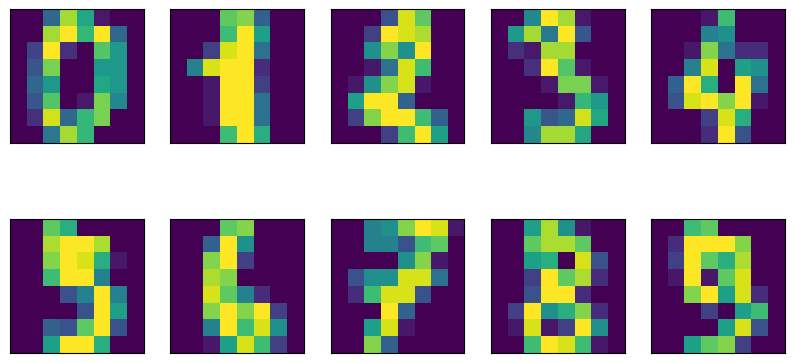

In [22]:
from sklearn.datasets import load_digits

digits = load_digits()
fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={"xticks": (), "yticks": ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

- Let's try PCA and visualize digits in two dimensions. 

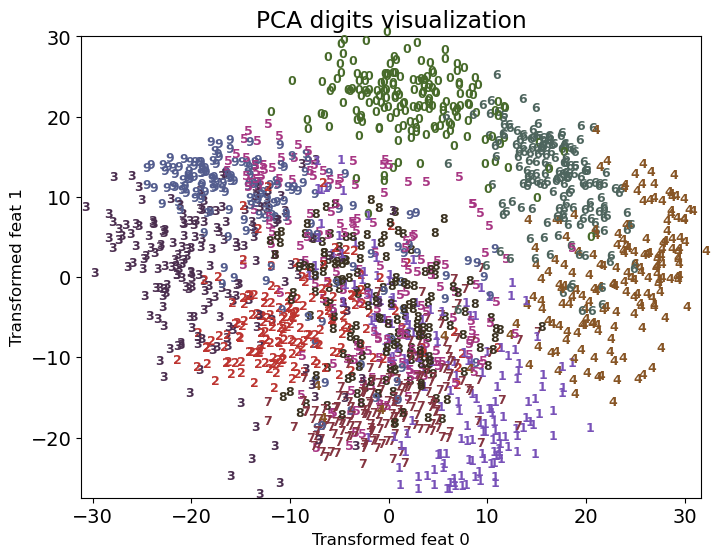

In [23]:
pca = PCA(n_components=2)
pca.fit(digits.data)
digits_pca = pca.transform(digits.data)
plot_digits(digits, digits_pca, title="PCA digits visualization")

- Let's try t-SNE to visualize digits in two dimensions. 

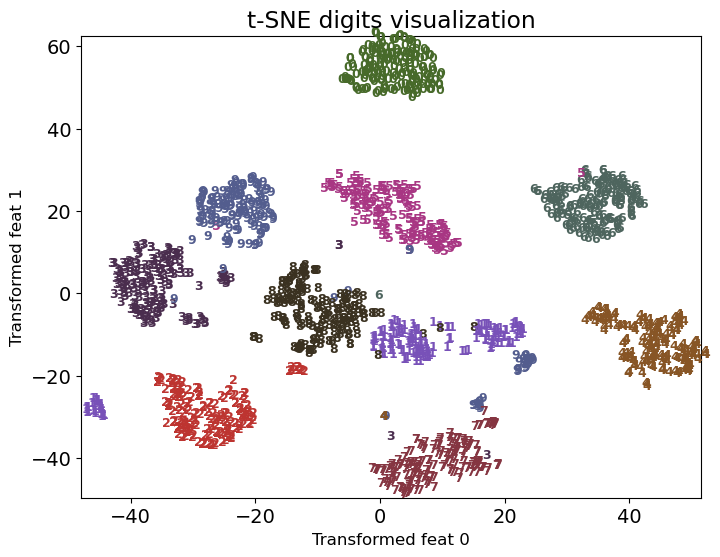

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=123)
digits_tsne = tsne.fit_transform(digits.data)
plot_digits(digits, digits_tsne, title="t-SNE digits visualization")

Much better separation of clusters. Remember that this is completely unsupervised! 

- Start with a random embedding (or PCA initialized embedding) in the lower dimensional space 
- Iteratively update points to make 
    - close points in the original space closer in the new space (more emphasis)
    - Far apart points in the original space further apart      

Let's try it out on the swiss roll toy dataset. 

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3

from sklearn.datasets import make_swiss_roll

X, colour = make_swiss_roll(n_samples=3000, noise=0.01)

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42, perplexity=30, init='pca')
swiss_tsne = tsne.fit_transform(X)

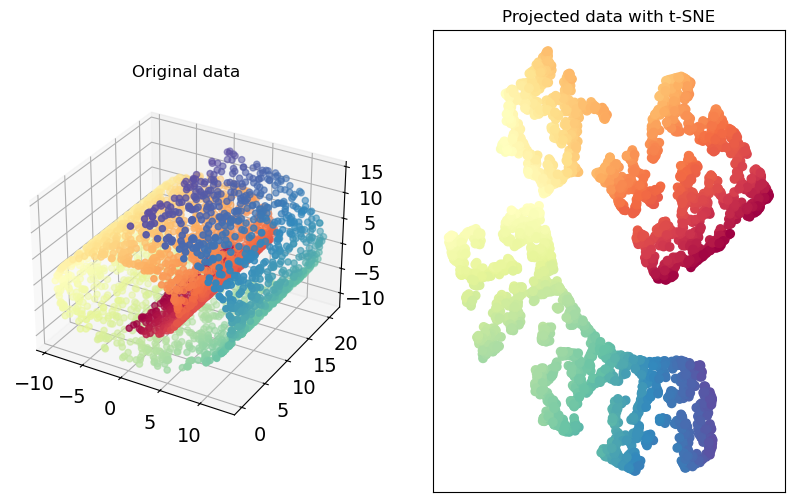

In [28]:
plot_swiss_roll(X, colour, swiss_tsne)

- It's identifying more or less clear clusters from this complicated structure.
- We're not going to talk about the details of the algorithm. 
- My goal is to give you an intuition, let you know that it exists, and show you how to use it for visualization. 

### 4.2.2 How does it work? (high-level)

- t-SNE is designed to measure how well the low-dimensional representation of the data preserves the pairwise similarities between points compared to the original high-dimensional data. 

**In the high-dimensional space**
- t-SNE begins by calculating the pairwise similarities between points as probabilities.
- The similarity between points $x_i$ and $x_j$ is represented by probability $p_{ij}$ which is high when the points are close together in the high-dimensional space and low when they are further apart.
- The probability is calculated using Gaussian distribution, centered at each point $x_i$. Then $p_{ij}$ is the density of $x_j$ under this Gaussian distribution.
- The variance of the Gaussian distribution is influenced by the hyperparameter `perplexity`.
- You can think of this probability as given that I'm at point $x_i$ what's the probability that $x_j$ is my neighbour. The `perplexity` hyperparamter determines how many neighbors effectively participate in the distribution. 

**In the low-dimensional space**
- t-SNE begins by randomly initializing the points in the low-dimensional map 
- Then it calculates a similar set of pairwise probabilities $q_{ij}$ in low-dimensional space
- Similar to high-dimensional space, these probabilities indicate how close or far apart the points are in the low-dimensional representation.
- The calculation uses a similar idea but with a crucial difference: it uses a **t-distribution** rather than a Gaussian distribution to calculate the probabilities in the lower-dimensional space to mitigate the "crowding problem".
- The heavier tails of t-distribution mean that it assigns a higher probability to events further away from the mean. This ensures that local structures are preserved and the distances between moderately distant points are exaggerated (compared to a Gaussian distribution), making clusters more distinct and easier to identify visually.

#### (Optional) 4.2.2 Loss function of t-SNE 

The loss function of t-SNE measures the mismatch between the high-dimensional probabilities $p_{ij}$ and the low-dimensional probabilities $q_{ij}$. It uses the Kullback-Leibler (KL) divergence to quantify the difference between two probability distributions. 

$$
KL(P||Q) = \sum_{i,j}p_{ij}\log\left(\frac{p_{ij}}{q_{ij}}\right)
$$

Where 
- $p_{ij} \rightarrow$ Similaries in the high-dimensional space
- $q_{ij} \rightarrow$ Similaries in the low-dimensional space

Intuitively, this loss function penalizes two types of errors:
- If two points are close in the high-dimensional space but far in the low-dimensional space, (high $p_{ij}$ but low $q_{ij}$), the loss will be high. 
- If two points are far away in the high-dimensional space but end up close in the low-dimensional space (low $p_{ij}$ but high $q_{ij}$), the loss is high (although to a lesser extent due to the log).
- The loss function is not symmetric, i.e., different error will be penalized differently.
- This method is focused on keeping the local structure. 
- There is a high penalty for putting neighbours far away. 


**(Optional) How to define $p_{ij}$ and $q_{ij}$?**

- In the original space, compute the following (Gaussian distribution):
$$
p_{j|i} = \frac{\exp(||x_{i}-x_j||^2/2\sigma_i^2)}{\sum_{i\neq k}\exp(||x_{i}-x_k||^2/2\sigma_i^2)},
$$
and $p_{i|i}=0$. Then, obtain the probability:

$$p_{ij} = \frac{p_{j|i}+p_{i|j}}{2n}$$

- For the projected points in the low dimensional space compute the following (t-distribution)
$$
q_{ij}= \frac{\left(1+||z_{i}-z_j||^2\right)^{-1}}{\sum_{i\neq k}\left(1+||z_{i}-z_k||^2\right)^{-1}}
$$

- In summary, t-SNE uses distances between points to come up with a probability distribution for the neighborhood of each point.
    - closer points have a higher probability to be neighbors
- Then, we look for a configuration in the low dimensional space that approximates these probabilities. 
- We have definitions for $p_{ij}$, $q_{ij}$ and the loss function. 
- You can use gradient-descent to optimize this function.

<br><br>

#### 4.2.3 Important hyperparameter: `perplexity`

Recall the t-SNE plot we saw before. 

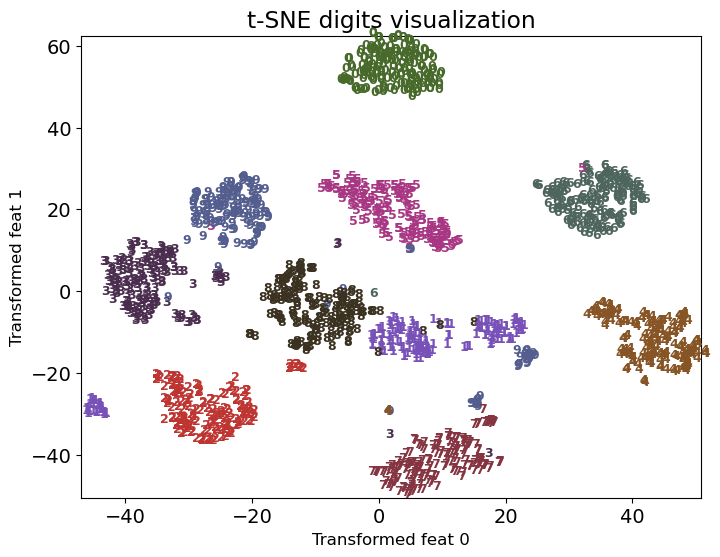

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
digits_tsne = tsne.fit_transform(digits.data)
plot_digits(digits, digits_tsne, title="t-SNE digits visualization")

- Almost all classes are clearly separated and form a single dense group. 
- Impressive given that it's a completely unsupervised method. 
- It's placing the points in two dimensions solely based on how close the points are in the original space. 
- Axes are not usually meaningful and do not correspond to anything in the input space.

![](img/t-sne-viz.gif)

[Source](https://github.com/oreillymedia/t-SNE-tutorial)

- Intuitively it refers to the bandwidth of neighbours to consider
    - low perplexity: consider only close neighbours
    - smaller datasets try lower perplexity
    - authors say perplexity of 30 always works well! 🪄     

Let's examine different perplexity values on the digits dataset. 

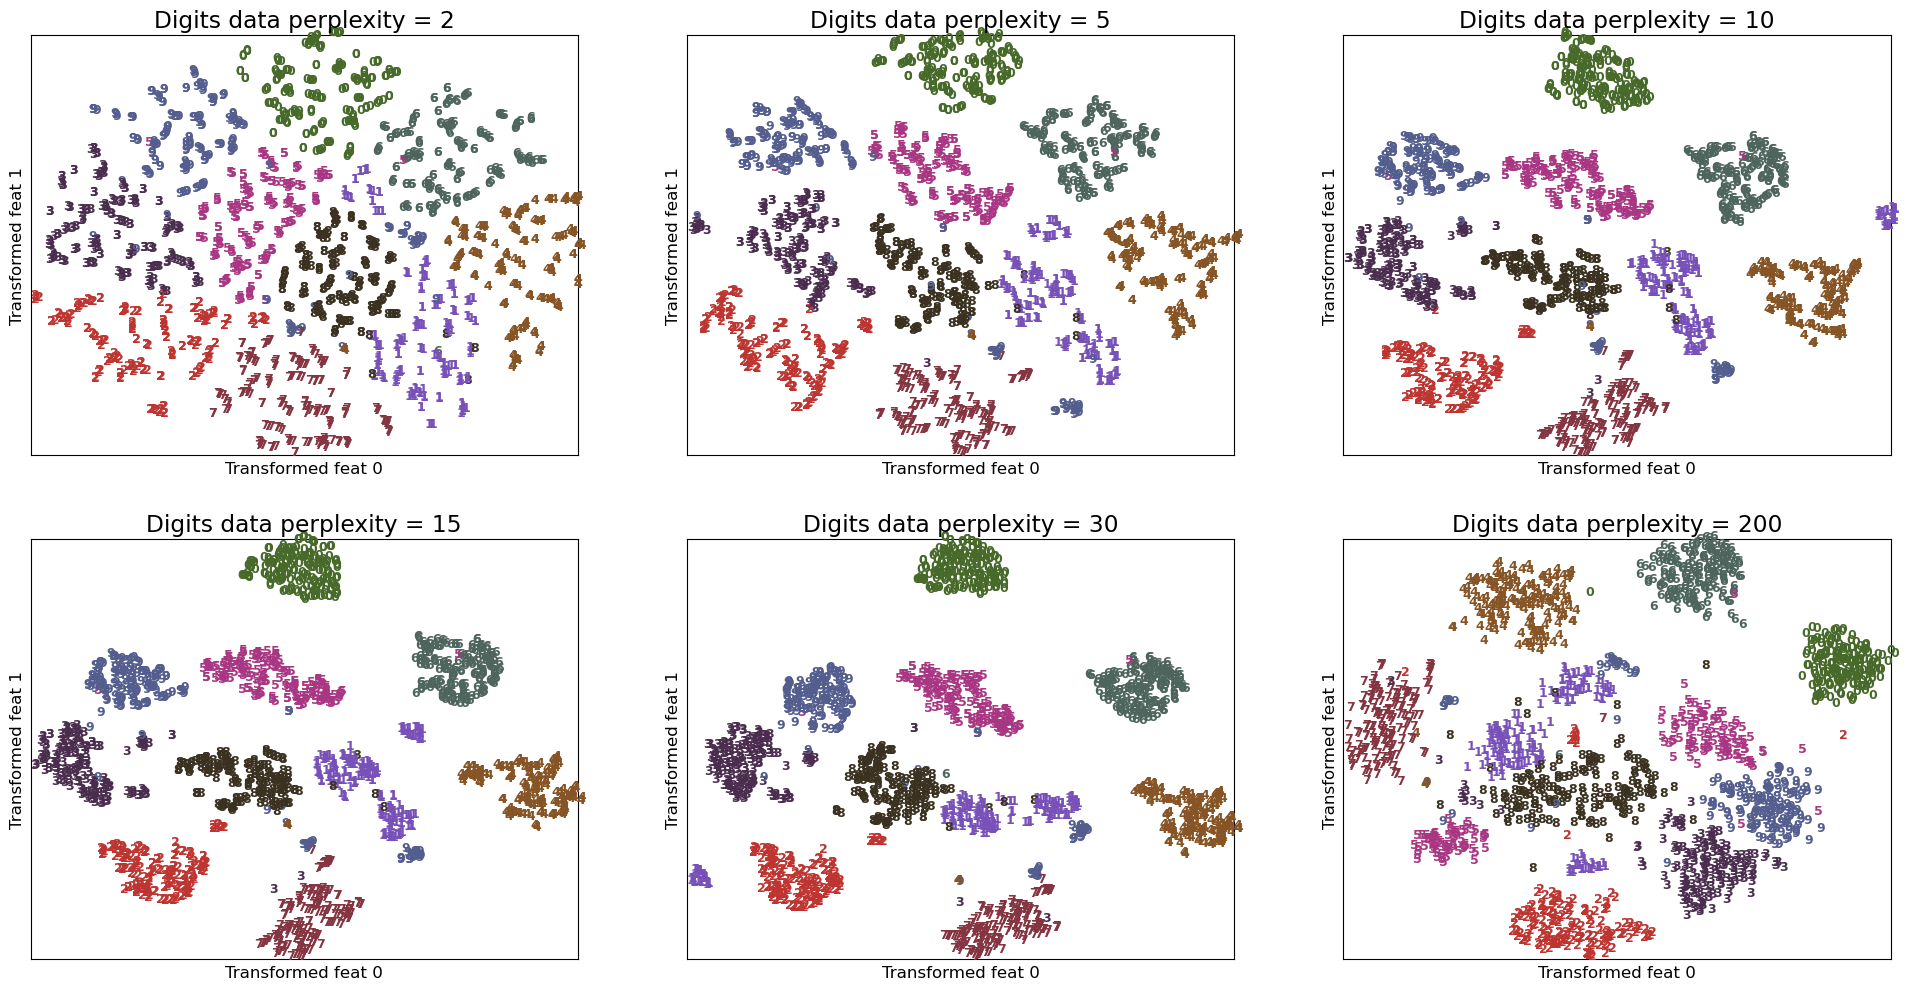

In [30]:
plot_perplexity_tsne(digits)

**Observations**

- For `perplexity=2` we only consider close neighbourhoods so the clusters do not look compact. 
- Perplexity values of 10, 15, 30 seem to produce reasonable clusters. 
- Perplexity of 30 is actually producing most compact clusters!! 

**Important points about t-SNE**

- Start with a random embedding
- Iteratively update points to make "close" points close.
- Local distances are more important and global distances are less important. 
- Good for getting coarse view of topology.
- t-distribution heavy-tailed so no overcrowding.
- low perplexity: only close neighbors
- It tends to be slower and does not scale well on large datasets.
- Results can vary significantly between different runs, especially due to its sensitivity to hyperparameters like perplexity and the random initialization.
- Lacks an easy way to embed new data points into an existing embedding without re-running the entire algorithm, which can be computationally intensive.

<br><br><br><br>

## ❓❓ Questions for you

### Exercise 6.2 Select all of the following statements which are **True** (iClicker)

- (A) In product recommendation application of word2vec above, we are not using item descriptions when training the model. 
- (B) Similar to PCA, t-SNE is a linear dimensionality reduction technique. 

<br><br><br><br>

Discuss the following questions. 

- Discuss how could you build a song recommendation system using word2vec. 
- Discuss the problems associated with word2vec recommendation systems. 

<br><br><br><br>

## 5. Final comments, summary, reflection

**Summary: Using word embeddings**

- It's not that straightforward to effectively use word representations directly in text classification tasks but later when we learn about sequential models such as recurrent neural networks (RNNs) you'll appreciate word representations more.  
- Two simplistic ways to use word embeddings with traditional ML models. 
    - Averaging (noisy but works OK if your text is not too long)
    - Concatenating (we have to chop some text)
- We can use them more naturally with sequential models such as recurrent neural networks (DSCI 575).

**Summary: word2vec beyond words**

- word2vec is not limited to text and words. You can use it wherever distributional hypothesis makes sense. 
- We looked an application of word2vec for product recommendation. 

**Summary: Manifold learning with t-SNE**

- Manifold learning algorithms apply complicated transformations on the data.  
    - Useful for pretty pictures and visualization. 
    - Usually we cannot use them to transform new data.     
- t-SNE focuses on neighbouring distances by allowing large variance in other distances. 
    - A popular technique used for visualizing high dimensional data
    - Usually produces well-separated and compact clusters compared to PCA
    - Axes do not correspond to anything meaningful in the input space    

## Resources

- [Visualizing data with t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)
- [Stochastic Neighbor Embedding](https://www.cs.toronto.edu/~hinton/absps/sne.pdf)
- [A nice video on detailed explanation of t-SNE](https://www.youtube.com/watch?v=MnRskV3NY1k)
- [t-SNE StatQuest](https://www.youtube.com/watch?v=NEaUSP4YerM)
- [t-SNE tutorial](https://github.com/oreillymedia/t-SNE-tutorial)
- [How to use t-SNE effectively](https://distill.pub/2016/misread-tsne/)
- [LargeVis](https://github.com/elbamos/largeVis)
- [UMAP](https://github.com/lmcinnes/umap)


<br><br><br><br>